In [ ]:
%%bash

pip install pandas \
    seaborn \
    sklearn \
    catboost \
    scikit-optimize tqdm \
    TPOT


In [291]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import json
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold
from tpot import TPOTClassifier

# Linear Methods
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier

# Ensemble methods
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier

# Multi layer perceptron
from sklearn.neural_network import MLPClassifier

# Suport Vector Machine
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, classification_report , confusion_matrix

from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import tqdm

Read Data

In [292]:
df = pd.read_csv('diabetes.csv')

print(f'Shape: {df.shape}\n')

df.head()

Shape: (768, 9)



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Features and labels

In [293]:
features = df.drop('Outcome', axis = 1)
labels = df['Outcome']

In [294]:
features = StandardScaler().fit_transform(features)

Train and test split

In [295]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = .2)

Models

In [306]:
models = {
    'Logistic Regression': LogisticRegression,
    'Catboost': CatBoostClassifier,
#     'Ridge': RidgeClassifier,
#     'AdaBoost': AdaBoostClassifier,
#     'Bagging': BaggingClassifier,
    'Gradient Boosting': GradientBoostingClassifier,
    'Random Forest': RandomForestClassifier,
    'KNeighborsClassifier': KNeighborsClassifier,
    'LinearSVC': LinearSVC,
    'SGDClassifier': SGDClassifier
}

param_search = {
    'Logistic Regression': {
        'penalty': ["l1", "l2"],
        'C': Real(1e-4, 25.),
        'solver': ['liblinear']
    },
    'Catboost': {
        'iterations': [100],
        'depth':Integer(2,10),
        'learning_rate': Real(.001, 1.0),
        'silent': [True],
        'l2_leaf_reg': Real(.01, 1.0)
        },
#     'Ridge': {
        
#     },
#     'AdaBoost': {
        
#     },
#     'Bagging': {
        
#     },
    'Gradient Boosting': {
        'learning_rate': Real(1e-3, 1.),
        'max_depth': Integer(1, 11),
        'min_samples_split': Integer(2, 21),
        'min_samples_leaf': Integer(1, 21),
        'subsample': Real(0.05, 1.),
        'max_features': Real(0.05, 1.)
    },
    'Random Forest': {
        'criterion': Categorical(["gini", "entropy"]),
        'max_features': Real(.05, 1.),
        'min_samples_split': Integer(2,21),
        'min_samples_leaf':  Integer(1,21),
        'bootstrap': [True, False]
    },
    'KNeighborsClassifier':{
        'n_neighbors': Integer(1, 101),
        'weights': ["uniform", "distance"],
        'p': [1, 2]
    },
    'LinearSVC':{
        'penalty': ["l1", "l2"],
        'loss': ["hinge", "squared_hinge"],
        'dual': [True, False],
        'tol': Real(1e-5, 1e-1),
        'C': Real(1e-4, 25.)
    },
    'SGDClassifier':{
        'loss': ['log', 'hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
        'penalty': ['elasticnet'],
        'alpha': Real(0.0, 0.001),
        'learning_rate': ['invscaling', 'constant'],
        'fit_intercept': [True, False],
        'l1_ratio': Real(0.25, 0.5),
        'eta0': Real(0.01, 0.1),
        'power_t': Real(0.5, 50.0)
    }
}

params = {i:{} for i in models}

fit_params = {
    'Logistic Regression': {},
    'Catboost': {'silent':True},
    'Ridge': {},
    'AdaBoost': {},
    'Bagging': {},
    'Gradient Boosting': {},
    'Random Forest': {},
    'KNeighborsClassifier': {},
    'LinearSVC': {},
    'SGDClassifier': {}
}

### Cross validation

Test with default parameters

In [307]:
%%time

# Remove Warnig messages
warnings.simplefilter('ignore')

cv = KFold(n_splits = 5)

scores = {}

for i in models:
    
    print(f'>> Model: {i}')
    
    score = cross_val_score(models[i](), features, labels, cv = cv, 
                             scoring = 'balanced_accuracy', fit_params = fit_params[i]
                            )
    scores[i] = {'mean': np.mean(score), 'all': score}
    
    print(f'Mean Score: {np.mean(score):.3f}\tSTD: {np.std(score):.3f}\tScores: {score}\n')
    
warnings.simplefilter('default')

>> Model: Logistic Regression
Mean Score: 0.727	STD: 0.022	Scores: [0.7312963  0.70347222 0.71522879 0.76788124 0.71801347]

>> Model: Catboost
Mean Score: 0.737	STD: 0.038	Scores: [0.70703704 0.7046875  0.74823657 0.8060054  0.72138047]

>> Model: Gradient Boosting
Mean Score: 0.740	STD: 0.032	Scores: [0.75833333 0.70138889 0.73946464 0.78879892 0.71127946]

>> Model: Random Forest
Mean Score: 0.729	STD: 0.041	Scores: [0.73407407 0.6734375  0.75492856 0.7891363  0.69444444]

>> Model: KNeighborsClassifier
Mean Score: 0.692	STD: 0.018	Scores: [0.68277778 0.6734375  0.71730874 0.71120108 0.67760943]

>> Model: LinearSVC
Mean Score: 0.730	STD: 0.022	Scores: [0.7412963  0.70347222 0.72038343 0.76788124 0.71801347]

>> Model: SGDClassifier
Mean Score: 0.697	STD: 0.048	Scores: [0.68222222 0.69704861 0.67914632 0.78475034 0.64141414]

CPU times: user 16.3 s, sys: 1.17 s, total: 17.4 s
Wall time: 9.12 s


### Parameter Tunning

In [308]:
%%time

# Remove Warnig messages
warnings.simplefilter('ignore')

cv = KFold(n_splits = 5)

for i in tqdm.tqdm(models):

    searcher = BayesSearchCV(
        estimator = models[i](), 
        search_spaces = param_search[i], 
        error_score = 0, n_iter = 50, cv = cv
    )

    searcher.fit(features, labels)

    params[i] = searcher.best_params_
    
warnings.simplefilter('default')

/Users/matheus/Documents/MBA FGV/Análise Preditiva Avançada/venv-analise-preditiva/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 7/7 [11:00<00:00, 94.36s/it]

CPU times: user 16min 30s, sys: 1min 59s, total: 18min 29s
Wall time: 11min


Store parameters on file

In [309]:
with open('params.json', 'w') as f:
    json.dump(params, f, indent = 4)

/Users/matheus/Documents/MBA FGV/Análise Preditiva Avançada/venv-analise-preditiva/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test again with parameters

In [310]:
%%time

cv = KFold(n_splits = 5)

scores = {}

for i in models:
    
    print(f'>> Model: {i}')
    
    score = cross_val_score(models[i](** params[i]), features, labels, cv = cv, 
                             scoring = 'balanced_accuracy', fit_params = fit_params[i]
                            )
    scores[i] = {'mean': np.mean(score), 'all': score}
    
    print(f'Mean Score: {np.mean(score):.3f}\tScores: {score}\n')

>> Model: Logistic Regression
Mean Score: 0.727	Scores: [0.7312963  0.69010417 0.72038343 0.76788124 0.72727273]

>> Model: Catboost
Mean Score: 0.737	Scores: [0.7162963  0.66892361 0.74823657 0.81916329 0.73063973]

>> Model: Gradient Boosting
Mean Score: 0.717	Scores: [0.71777778 0.66996528 0.72707542 0.77631579 0.69360269]

>> Model: Random Forest
Mean Score: 0.737	Scores: [0.73555556 0.6734375  0.74100199 0.80195682 0.73148148]

>> Model: KNeighborsClassifier
Mean Score: 0.700	Scores: [0.73       0.6453125  0.71260626 0.74662618 0.66414141]

>> Model: LinearSVC
Mean Score: 0.725	Scores: [0.7412963  0.70347222 0.70645686 0.76788124 0.70791246]

>> Model: SGDClassifier
Mean Score: 0.721	Scores: [0.71703704 0.70347222 0.72038343 0.75067476 0.71380471]

CPU times: user 2.92 s, sys: 219 ms, total: 3.14 s
Wall time: 2.75 s


/Users/matheus/Documents/MBA FGV/Análise Preditiva Avançada/venv-analise-preditiva/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/matheus/Documents/MBA FGV/Análise Preditiva Avançada/venv-analise-preditiva/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/matheus/Documents/MBA FGV/Análise Preditiva Avançada/venv-analise-preditiva/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/matheus/Documents/MBA FGV/Análise Preditiva Avançada/venv-analise-preditiva/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarn

Make Predictions

In [311]:
predictions = {}

for i in models:
    predictions[i] = cross_val_predict(models[i](** fit_params[i]), features, labels)

predictions_df = pd.DataFrame(predictions)

/Users/matheus/Documents/MBA FGV/Análise Preditiva Avançada/venv-analise-preditiva/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/matheus/Documents/MBA FGV/Análise Preditiva Avançada/venv-analise-preditiva/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/matheus/Documents/MBA FGV/Análise Preditiva Avançada/venv-analise-preditiva/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/m

### Ensemble with vote

In [312]:
pred_vote = np.round(predictions_df.mean(axis = 1))

/Users/matheus/Documents/MBA FGV/Análise Preditiva Avançada/venv-analise-preditiva/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


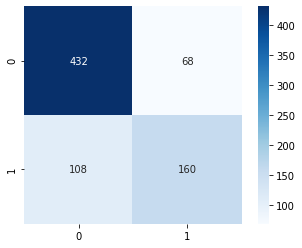

In [313]:
sns.heatmap(
    confusion_matrix(labels, pred_vote),
    cmap="Blues", square=True, annot = True, fmt = '.0f'
)

plt.show()

In [314]:
print(classification_report(labels, pred_vote))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       500
           1       0.70      0.60      0.65       268

    accuracy                           0.77       768
   macro avg       0.75      0.73      0.74       768
weighted avg       0.77      0.77      0.77       768



### TPOT auto ml

In [ ]:
# Create a tpot optimizer with parameters
tpot = TPOTClassifier(scoring = 'balanced_accuracy', 
                     max_time_mins = 480, 
                     n_jobs = -1,
                     verbosity = 2,
                     cv = 5)

tp_fit = tpot.fit(features, labels)

tpot.export('diabetes_pipeline.py')

# TO DO
- [x] Cross Validation: from sklearn.model_selection import cross_val_score
- [x] CV Search \
- [ ] Imbalanced Learning "pip install -U --user imbalanced-learn" "from imblearn.over_sampling import SMOTENC"